# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it


## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/EhWeqeQsh-9Mr1fneZc9_0sBOBzEdXngvxFJtAlIa-eAgA?e=8ukWwa). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

# Step 1: Problem formulation and data collection

The company operates a **travel booking website** that wants to enhance user experience by showing the *likelihood of flight delays* before customers make bookings.  
Using five years of US domestic flight records (2014–2018) from the Bureau of Transportation Statistics, the goal is to build a **machine learning model** that predicts whether a flight will be delayed by 15 minutes or more.

**Business metric**  
The key metric is **model accuracy and ROC-AUC** on unseen data.  
A ROC-AUC ≥ 0.65 is considered acceptable for initial deployment, with the long-term goal of 0.70+.  

**ML problem statement**  
> Given the flight’s scheduled details (origin, destination, airline, month, day, time, distance, etc.), predict whether the flight will be delayed (DELAYED = 1) or on-time (DELAYED = 0).

This is a **supervised binary-classification** problem that can improve customer transparency and platform trust.

### 1. Determine if and why ML is an appropriate solution to deploy.

Flight delays depend on multiple nonlinear factors—route congestion, carrier operations, weather, time of day, and seasonal peaks.  
Static business rules fail to capture such complexity. **Machine Learning** can generalise from millions of historical flights, learning hidden patterns that affect delay likelihood.  
Therefore, ML is the most suitable approach to provide reliable delay-risk predictions to users at booking time.

### 2. Formulate the business problem, success metrics, and desired ML output.

**Business problem:**  
Predict whether a flight will be delayed by at least 15 minutes at the time of booking.

**Desired ML output:**  
A binary classification model outputting `0 = On-time` or `1 = Delayed`, plus a probability score that can be displayed to customers.

**Success metrics:**  
- ROC-AUC ≥ 0.65 (acceptable baseline)  
- Accuracy ≈ 0.60 – 0.62 (achieved on-premises)  
- Balanced precision/recall to avoid bias toward majority class  
- Model runtime < 2 s per prediction for web deployment

### 3. Identify the type of ML problem you’re dealing with.

This is a **supervised learning** task because we have historical labelled examples (`DELAYED` = 0/1).  
The model must predict a **binary categorical outcome**, which makes it a **classification** problem.  
The primary algorithms evaluated in Part A are:
- Logistic Regression (baseline, interpretable)  
- Random Forest Classifier (non-linear, higher accuracy)

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [218]:
# --- Core setup (paths consistent with your folder layout) ---
import os, sys, glob, time, zipfile, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# Helper: robustly detect project root
# ------------------------------------------------------------
def find_project_root(start: Path = Path.cwd()) -> Path:
    """
    Find the project root dynamically.
    - If the notebook runs from inside 'scripts/', use its parent as root.
    - Otherwise, search upward for a directory that contains 'scripts/'.
    """
    p = start.resolve()
    if p.name.lower() == "scripts":
        return p.parent
    for cand in [p, *p.parents]:
        if (cand / "scripts").is_dir():
            return cand
    return start  # fallback if not found

# ------------------------------------------------------------
# Define consistent folder paths
# ------------------------------------------------------------
PROJECT_ROOT = find_project_root()

# Separate paths for raw ZIPs and extracted CSVs
DATA_RAW_ZIPS       = PROJECT_ROOT / "data_raw"                 # where 60 ZIPs live
DATA_RAW_EXTRACTED  = DATA_RAW_ZIPS / "extracted_csv"           # extracted CSV files
DATA_PROCESSED      = PROJECT_ROOT / "data_processed"           # cleaned/combined files
CLOUD_DATA          = PROJECT_ROOT / "cloud_data"               # train/test for AWS
FIGS                = PROJECT_ROOT / "figs"
ARTIFACTS           = PROJECT_ROOT / "artifacts"
SCRIPTS             = PROJECT_ROOT / "scripts"

# ------------------------------------------------------------
# Ensure all directories exist
# ------------------------------------------------------------
for d in [DATA_RAW_ZIPS, DATA_RAW_EXTRACTED, DATA_PROCESSED, CLOUD_DATA, FIGS, ARTIFACTS, SCRIPTS]:
    d.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# Diagnostics / Confirmation
# ------------------------------------------------------------
print("✅ Project folders ready.")
print(f"Root:              {PROJECT_ROOT}")
print(f"RAW ZIPs:          {DATA_RAW_ZIPS}")
print(f"Extracted CSVs:    {DATA_RAW_EXTRACTED}")
print(f"Processed:         {DATA_PROCESSED}")
print(f"Cloud data:        {CLOUD_DATA}")
print(f"Figs:              {FIGS}")
print(f"Artifacts:         {ARTIFACTS}")

# Warn if someone has mistakenly nested folders under scripts/
nested = [p for p in (SCRIPTS.glob("*")) if p.is_dir() and p.name in 
          {"data_raw", "data_processed", "cloud_data", "figs", "artifacts"}]
if nested:
    print("\n⚠️ Detected folders under 'scripts/' that should live at project root:")
    for p in nested:
        print("   -", p)
    print("These will be ignored; correct folders are at the project root.")


✅ Project folders ready.
Root:              C:\Users\DELL\Documents\flight_delay_project
RAW ZIPs:          C:\Users\DELL\Documents\flight_delay_project\data_raw
Extracted CSVs:    C:\Users\DELL\Documents\flight_delay_project\data_raw\extracted_csv
Processed:         C:\Users\DELL\Documents\flight_delay_project\data_processed
Cloud data:        C:\Users\DELL\Documents\flight_delay_project\cloud_data
Figs:              C:\Users\DELL\Documents\flight_delay_project\figs
Artifacts:         C:\Users\DELL\Documents\flight_delay_project\artifacts


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [220]:
# ------------------------------------------------------------
# Optional: download ZIPs if URLs are provided
# ------------------------------------------------------------

ZIP_URLS = []  # Example: ["https://.../On_Time_Reporting_Carrier_On_Time_Performance_2014_1.zip", ...]

def download_if_needed(urls, dest_dir):
    """Download ZIP files only if they don't already exist locally."""
    import urllib.request
    downloaded = 0

    for url in urls:
        fname = url.split("/")[-1]
        out = dest_dir / fname

        if out.exists():
            print(f"✅ Already exists: {fname}")
            continue

        try:
            print(f"⬇️ Downloading {fname} ...")
            urllib.request.urlretrieve(url, out.as_posix())
            downloaded += 1
        except Exception as e:
            print(f"❌ Failed to download {url}\n   Error: {e}")

    print(f"\nDownload complete. Newly downloaded files: {downloaded}")
    print(f"All ZIPs are stored in: {dest_dir}")

# If you have URLs, uncomment this line to download automatically:
# download_if_needed(ZIP_URLS, DATA_RAW_ZIPS)

print("\nIf you already have the ZIP files, make sure they are located in:")
print("📂", DATA_RAW_ZIPS)



If you already have the ZIP files, make sure they are located in:
📂 C:\Users\DELL\Documents\flight_delay_project\data_raw


In [222]:
# ------------------------------------------------------------
# List all ZIP files available in the data_raw folder
# ------------------------------------------------------------
import glob

zip_files = sorted(glob.glob(str(DATA_RAW_ZIPS / "*.zip")))
print(f"Found {len(zip_files)} ZIP files in {DATA_RAW_ZIPS}")

# Expectation: 60 files covering 2014–2018 months
if len(zip_files) == 0:
    print("⚠️ No ZIP files found yet. Please place the 60 monthly ZIPs into:", DATA_RAW_ZIPS)

# Show the first 5 ZIP filenames as a quick preview
zip_files[:5]



Found 60 ZIP files in C:\Users\DELL\Documents\flight_delay_project\data_raw


['C:\\Users\\DELL\\Documents\\flight_delay_project\\data_raw\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip',
 'C:\\Users\\DELL\\Documents\\flight_delay_project\\data_raw\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip',
 'C:\\Users\\DELL\\Documents\\flight_delay_project\\data_raw\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip',
 'C:\\Users\\DELL\\Documents\\flight_delay_project\\data_raw\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip',
 'C:\\Users\\DELL\\Documents\\flight_delay_project\\data_raw\\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip']

#### Extract CSV files from ZIP files

In [224]:
# ------------------------------------------------------------
# Locate ZIP files and confirm paths
# ------------------------------------------------------------
zip_path = DATA_RAW_ZIPS           # Folder containing the 60 monthly ZIPs
csv_base_path = DATA_RAW_EXTRACTED # Destination folder for extracted CSVs

print("ZIP source path:", zip_path)
zips = list(zip_path.glob("*.zip"))
print(f"Found {len(zips)} ZIP files in {zip_path}")

# Show the first 10 ZIP filenames as a quick sanity check
for z in zips[:10]:
    print("-", z.name)

if len(zips) == 0:
    print("⚠️ No ZIP files found. Make sure all monthly ZIPs are in:", zip_path)



ZIP source path: C:\Users\DELL\Documents\flight_delay_project\data_raw
Found 60 ZIP files in C:\Users\DELL\Documents\flight_delay_project\data_raw
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip


In [226]:
# ------------------------------------------------------------
# Extract all monthly ZIPs into extracted_csv folder
# ------------------------------------------------------------
from zipfile import ZipFile
from pathlib import Path
import zipfile

def zip2csv(zip_file_path: Path, extract_to: Path) -> Path:
    """
    Extract a single CSV from a monthly BTS on-time ZIP.
    - Assumes each ZIP contains exactly one CSV.
    - Returns the full path to the extracted CSV.
    """
    zip_file_path = Path(zip_file_path)
    extract_to = Path(extract_to)
    extract_to.mkdir(parents=True, exist_ok=True)

    with ZipFile(zip_file_path, 'r') as z:
        csv_members = [m for m in z.namelist() if m.lower().endswith(".csv")]
        if not csv_members:
            raise ValueError(f"No CSV found in {zip_file_path.name}")

        member = csv_members[0]
        safe_name = zip_file_path.stem + ".csv"
        target = extract_to / safe_name

        # Only extract if not already present
        if not target.exists():
            z.extract(member, path=extract_to)
            extracted = extract_to / member
            if extracted.exists() and extracted != target:
                extracted.rename(target)

        return target

def extract_all_zips(zip_dir: Path, output_dir: Path) -> list:
    """
    Batch extract all ZIP files from zip_dir to output_dir/extracted_csv.
    Skips files that have already been extracted.
    """
    zip_dir = Path(zip_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    zips = sorted(zip_dir.glob("*.zip"))
    csv_paths = []

    for zp in zips:
        csv_path = zip2csv(zp, output_dir)
        csv_paths.append(csv_path)
        print(f"✅ Extracted or found: {zp.name}")

    print(f"\nTotal CSVs available: {len(csv_paths)}")
    print(f"All extracted files are stored in: {output_dir}")
    return sorted(csv_paths)

# ------------------------------------------------------------
# Run extraction only if needed
# ------------------------------------------------------------
csv_files = extract_all_zips(DATA_RAW_ZIPS, DATA_RAW_EXTRACTED)

print("\nExample extracted CSVs:")
csv_files[:5]


✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip
✅ Extracted or found: On_Time_Reporting_Carrier_On_Time_Performance_1987_pres

[WindowsPath('C:/Users/DELL/Documents/flight_delay_project/data_raw/extracted_csv/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.csv'),
 WindowsPath('C:/Users/DELL/Documents/flight_delay_project/data_raw/extracted_csv/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.csv'),
 WindowsPath('C:/Users/DELL/Documents/flight_delay_project/data_raw/extracted_csv/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.csv'),
 WindowsPath('C:/Users/DELL/Documents/flight_delay_project/data_raw/extracted_csv/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.csv'),
 WindowsPath('C:/Users/DELL/Documents/flight_delay_project/data_raw/extracted_csv/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.csv')]

In [182]:
from zipfile import ZipFile

# pick a sample ZIP automatically (prefer 2018_9 if available)
zips = sorted(zip_path.glob("*.zip"))
sample_zip = next((p for p in zips if "2018_9" in p.name), zips[-1])
print("Using sample ZIP:", sample_zip.name)

with ZipFile(sample_zip, "r") as z:
    members = z.namelist()
    readme = next((m for m in members if m.lower().endswith("readme.html")), None)
    sample_csv_in_zip = next((m for m in members if m.lower().endswith(".csv")), None)
    if readme:
        z.extract(readme, path=csv_base_path)
        print("Extracted:", readme)
    if sample_csv_in_zip:
        z.extract(sample_csv_in_zip, path=csv_base_path)
        print("Extracted:", sample_csv_in_zip)

readme_path = next(csv_base_path.rglob("readme.html"), None)
sample_csv_path = next(csv_base_path.rglob("*.csv"), None)

print("readme_path:", readme_path)
print("sample_csv_path:", sample_csv_path)


Using sample ZIP: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_9.zip
Extracted: readme.html
Extracted: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv
readme_path: C:\Users\DELL\Documents\flight_delay_project\data_processed\readme.html
sample_csv_path: C:\Users\DELL\Documents\flight_delay_project\data_processed\combined_csv_v1.csv


In [228]:
# ------------------------------------------------------------
# Inspect extracted CSV files
# ------------------------------------------------------------
csv_files = sorted(DATA_RAW_EXTRACTED.rglob("*.csv"))

print(f"✅ CSV files currently extracted to: {DATA_RAW_EXTRACTED}")
print(f"Total extracted CSV files: {len(csv_files)}")

# Show the first 5 CSVs for a quick check
for p in csv_files[:5]:
    print("-", p.name)

if len(csv_files) == 0:
    print("⚠️ No CSV files found! Make sure extraction completed successfully.")



✅ CSV files currently extracted to: C:\Users\DELL\Documents\flight_delay_project\data_raw\extracted_csv
Total extracted CSV files: 60
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.csv
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.csv
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.csv
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.csv
- On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.csv


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [230]:
# ------------------------------------------------------------
# Display the dataset documentation HTML (if available)
# ------------------------------------------------------------
from IPython.display import IFrame

# Look for any readme.html file in extracted_csv folder
readme_candidates = list(DATA_RAW_EXTRACTED.rglob("readme.html"))

if readme_candidates:
    readme_path = readme_candidates[0]  # Take the first one found
    print(f"✅ Found readme file at: {readme_path}")
    display(IFrame(src=readme_path.as_posix(), width=1000, height=600))
else:
    print("⚠️ No readme.html found in extracted folder.")
    print("   Some monthly ZIPs may not include a metadata HTML file.")
    print("   Make sure you extracted all ZIPs into:", DATA_RAW_EXTRACTED)


⚠️ No readme.html found in extracted folder.
   Some monthly ZIPs may not include a metadata HTML file.
   Make sure you extracted all ZIPs into: C:\Users\DELL\Documents\flight_delay_project\data_raw\extracted_csv


#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [232]:
# ------------------------------------------------------------
# Load one sample extracted CSV to inspect its structure
# ------------------------------------------------------------

# Pick a sample CSV — automatically chooses one if not manually set
sample_file = DATA_RAW_EXTRACTED / "On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_9.csv"

if not sample_file.exists():
    # If that exact file isn’t found, just grab the first available CSV
    extracted_csvs = sorted(DATA_RAW_EXTRACTED.glob("*.csv"))
    if len(extracted_csvs) == 0:
        raise FileNotFoundError(f"⚠️ No extracted CSVs found in {DATA_RAW_EXTRACTED}. Run the extraction cell first.")
    sample_file = extracted_csvs[0]

print(f"✅ Previewing sample file: {sample_file.name}")
print(f"📂 Location: {sample_file.parent}")

# Read a few rows from the sample file
df_temp = pd.read_csv(sample_file, low_memory=False)

print(f"\n✅ Sample CSV loaded successfully — Shape: {df_temp.shape}")
df_temp.head(5)


✅ Previewing sample file: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_9.csv
📂 Location: C:\Users\DELL\Documents\flight_delay_project\data_raw\extracted_csv

✅ Sample CSV loaded successfully — Shape: (585749, 110)


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1307.0,-8.0,0.0,0.0,-1.0,1300-1359,32.0,1339.0,1627.0,4.0,1629,1631.0,2.0,2.0,0.0,0.0,1600-1659,0.0,NaN,0.0,134.0,144.0,108.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1307.0,-8.0,0.0,0.0,-1.0,1300-1359,21.0,1328.0,1610.0,4.0,1629,1614.0,-15.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,127.0,102.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1310.0,-5.0,0.0,0.0,-1.0,1300-1359,19.0,1329.0,1613.0,5.0,1629,1618.0,-11.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,128.0,104.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1313.0,-2.0,0.0,0.0,-1.0,1300-1359,14.0,1327.0,1613.0,4.0,1629,1617.0,-12.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,124.0,106.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1311.0,-4.0,0.0,0.0,-1.0,1300-1359,15.0,1326.0,1614.0,5.0,1629,1619.0,-10.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,128.0,108.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

**Question**: Print the row and column length in the dataset, and print the column names.

In [234]:
# ------------------------------------------------------------
# Inspect the shape and columns of the sample CSV
# ------------------------------------------------------------

# Confirm that df_temp is loaded
if 'df_temp' not in locals() or df_temp is None:
    raise RuntimeError("⚠️ DataFrame 'df_temp' not found. Run the sample loading cell first.")

# Get shape
rows, cols = df_temp.shape
print(f"✅ The sample CSV contains {rows:,} rows and {cols} columns.\n")

# Display column names neatly
print("📋 Column names in the dataset:\n")
for i, col in enumerate(df_temp.columns, start=1):
    print(f"{i:>2}. {col}")

# Optional: show total count
print(f"\nTotal columns: {len(df_temp.columns)}")


✅ The sample CSV contains 585,749 rows and 110 columns.

📋 Column names in the dataset:

 1. Year
 2. Quarter
 3. Month
 4. DayofMonth
 5. DayOfWeek
 6. FlightDate
 7. Reporting_Airline
 8. DOT_ID_Reporting_Airline
 9. IATA_CODE_Reporting_Airline
10. Tail_Number
11. Flight_Number_Reporting_Airline
12. OriginAirportID
13. OriginAirportSeqID
14. OriginCityMarketID
15. Origin
16. OriginCityName
17. OriginState
18. OriginStateFips
19. OriginStateName
20. OriginWac
21. DestAirportID
22. DestAirportSeqID
23. DestCityMarketID
24. Dest
25. DestCityName
26. DestState
27. DestStateFips
28. DestStateName
29. DestWac
30. CRSDepTime
31. DepTime
32. DepDelay
33. DepDelayMinutes
34. DepDel15
35. DepartureDelayGroups
36. DepTimeBlk
37. TaxiOut
38. WheelsOff
39. WheelsOn
40. TaxiIn
41. CRSArrTime
42. ArrTime
43. ArrDelay
44. ArrDelayMinutes
45. ArrDel15
46. ArrivalDelayGroups
47. ArrTimeBlk
48. Cancelled
49. CancellationCode
50. Diverted
51. CRSElapsedTime
52. ActualElapsedTime
53. AirTime
54. Flights


**Question**: Print the first 10 rows of the dataset.  

In [236]:
# ------------------------------------------------------------
# Display the first 10 rows of the sample dataset
# ------------------------------------------------------------
import pandas as pd

# Ensure DataFrame is available
if 'df_temp' not in locals() or df_temp is None:
    raise RuntimeError("⚠️ DataFrame 'df_temp' not found. Run the sample loading cell first.")

# Show all columns for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

print("✅ Displaying the first 10 rows of the dataset:\n")
df_temp.head(10)



✅ Displaying the first 10 rows of the dataset:



,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1307.0,-8.0,0.0,0.0,-1.0,1300-1359,32.0,1339.0,1627.0,4.0,1629,1631.0,2.0,2.0,0.0,0.0,1600-1659,0.0,NaN,0.0,134.0,144.0,108.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1307.0,-8.0,0.0,0.0,-1.0,1300-1359,21.0,1328.0,1610.0,4.0,1629,1614.0,-15.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,127.0,102.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1310.0,-5.0,0.0,0.0,-1.0,1300-1359,19.0,1329.0,1613.0,5.0,1629,1618.0,-11.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,128.0,104.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1313.0,-2.0,0.0,0.0,-1.0,1300-1359,14.0,1327.0,1613.0,4.0,1629,1617.0,-12.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,124.0,106.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,3280,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11193,1119302,33105,CVG,"Cincinnati, OH",KY,21,Kentucky,52,1315,1311.0,-4.0,0.0,0.0,-1.0,1300-1359,15.0,1326.0,1614.0,5.0,1629,1619.0,-10.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,134.0,128.0,108.0,1.0,812.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [238]:
# ------------------------------------------------------------
# Print all column names in the sample dataset
# ------------------------------------------------------------

# Safety check
if 'df_temp' not in locals() or df_temp is None:
    raise RuntimeError("⚠️ DataFrame 'df_temp' not found. Run the sample loading cell first.")

print("📋 Column names in the sample dataset:\n")

# Enumerate and display neatly
for i, col in enumerate(df_temp.columns, start=1):
    print(f"{i:>2}. {col}")

print(f"\n✅ Total columns: {len(df_temp.columns)}")


📋 Column names in the sample dataset:

 1. Year
 2. Quarter
 3. Month
 4. DayofMonth
 5. DayOfWeek
 6. FlightDate
 7. Reporting_Airline
 8. DOT_ID_Reporting_Airline
 9. IATA_CODE_Reporting_Airline
10. Tail_Number
11. Flight_Number_Reporting_Airline
12. OriginAirportID
13. OriginAirportSeqID
14. OriginCityMarketID
15. Origin
16. OriginCityName
17. OriginState
18. OriginStateFips
19. OriginStateName
20. OriginWac
21. DestAirportID
22. DestAirportSeqID
23. DestCityMarketID
24. Dest
25. DestCityName
26. DestState
27. DestStateFips
28. DestStateName
29. DestWac
30. CRSDepTime
31. DepTime
32. DepDelay
33. DepDelayMinutes
34. DepDel15
35. DepartureDelayGroups
36. DepTimeBlk
37. TaxiOut
38. WheelsOff
39. WheelsOn
40. TaxiIn
41. CRSArrTime
42. ArrTime
43. ArrDelay
44. ArrDelayMinutes
45. ArrDel15
46. ArrivalDelayGroups
47. ArrTimeBlk
48. Cancelled
49. CancellationCode
50. Diverted
51. CRSElapsedTime
52. ActualElapsedTime
53. AirTime
54. Flights
55. Distance
56. DistanceGroup
57. CarrierDelay
58

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [240]:
# ------------------------------------------------------------
# Identify and print columns containing the substring 'Del' (case-insensitive)
# ------------------------------------------------------------

# Safety check
if 'df_temp' not in locals() or df_temp is None:
    raise RuntimeError("⚠️ DataFrame 'df_temp' not found. Run the sample loading cell first.")

# Find all columns with 'del' in their name (case-insensitive)
delay_cols = [col for col in df_temp.columns if 'del' in col.lower()]

# Display results neatly
if delay_cols:
    print(f"✅ Found {len(delay_cols)} columns related to delays:\n")
    for i, col in enumerate(delay_cols, start=1):
        print(f"{i:>2}. {col}")
else:
    print("⚠️ No columns containing 'Del' found in the dataset.")


✅ Found 14 columns related to delays:

 1. DepDelay
 2. DepDelayMinutes
 3. DepDel15
 4. DepartureDelayGroups
 5. ArrDelay
 6. ArrDelayMinutes
 7. ArrDel15
 8. ArrivalDelayGroups
 9. CarrierDelay
10. WeatherDelay
11. NASDelay
12. SecurityDelay
13. LateAircraftDelay
14. DivArrDelay


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [242]:
# ------------------------------------------------------------
# Quick Summary Analysis for the Sample Dataset
# ------------------------------------------------------------

# ✅ Safety check
if 'df_temp' not in locals() or df_temp is None:
    raise RuntimeError("⚠️ DataFrame 'df_temp' not found. Run the sample loading cell first.")

# 1️⃣ Rows and Columns
rows, cols = df_temp.shape
print(f"1️⃣ The dataset has {rows:,} rows and {cols} columns.\n")

# 2️⃣ Years Included
year_col = next((c for c in df_temp.columns if c.lower() in ["year"]), None)
if year_col:
    years = sorted(df_temp[year_col].dropna().unique().tolist())
else:
    years = []
print(f"2️⃣ Years included in the dataset: {years if years else 'Not available'}\n")

# 3️⃣ Date Range (handles all naming variations)
date_col = None
if 'FL_DATE' in df_temp.columns:
    df_temp['date_temp'] = pd.to_datetime(df_temp['FL_DATE'], errors='coerce')
    date_col = 'FL_DATE'
elif all(col in df_temp.columns for col in ['Year', 'Month', 'DayofMonth']):
    df_temp['date_temp'] = pd.to_datetime(
        df_temp[['Year', 'Month', 'DayofMonth']].rename(
            columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'}
        ), 
        errors='coerce'
    )
    date_col = 'Year/Month/DayofMonth'
elif all(col in df_temp.columns for col in ['YEAR', 'MONTH', 'DAY_OF_MONTH']):
    df_temp['date_temp'] = pd.to_datetime(
        df_temp[['YEAR', 'MONTH', 'DAY_OF_MONTH']].rename(
            columns={'YEAR': 'year', 'MONTH': 'month', 'DAY_OF_MONTH': 'day'}
        ), 
        errors='coerce'
    )
    date_col = 'YEAR/MONTH/DAY_OF_MONTH'
elif all(col in df_temp.columns for col in ['Year', 'Month']):
    df_temp['date_temp'] = pd.to_datetime(
        df_temp['Year'].astype(int).astype(str) + "-" + df_temp['Month'].astype(int).astype(str) + "-01",
        errors='coerce'
    )
    date_col = 'Year/Month (day=01)'
else:
    df_temp['date_temp'] = pd.NaT
    print("⚠️ No suitable date columns found.\n")

# Display Date Range
if df_temp['date_temp'].notna().any():
    min_date, max_date = df_temp['date_temp'].min(), df_temp['date_temp'].max()
    print(f"3️⃣ Date range ({date_col}): {min_date.date()} to {max_date.date()}\n")
else:
    print("3️⃣ Date range could not be determined.\n")

# 4️⃣ Airlines Summary
airline_cols = ['Reporting_Airline', 'IATA_CODE_Reporting_Airline']
airline_col = next((c for c in airline_cols if c in df_temp.columns), None)
airlines = sorted(df_temp[airline_col].dropna().unique()) if airline_col else []
print(f"4️⃣ Number of airlines: {len(airlines)}")
print(f"   Airlines included: {airlines if airlines else 'Not available'}\n")

# 5️⃣ Origin & Destination Airports
origins = sorted(df_temp['Origin'].dropna().unique()) if 'Origin' in df_temp.columns else []
dests = sorted(df_temp['Dest'].dropna().unique()) if 'Dest' in df_temp.columns else []

print(f"5️⃣ Number of origin airports: {len(origins)}")
print(f"   Number of destination airports: {len(dests)}")

if origins and dests:
    print(f"   Example origins: {origins[:10]}")
    print(f"   Example destinations: {dests[:10]}")
else:
    print("⚠️ Origin/Destination data not available.")


1️⃣ The dataset has 585,749 rows and 110 columns.

2️⃣ Years included in the dataset: [2018]

3️⃣ Date range (Year/Month/DayofMonth): 2018-09-01 to 2018-09-30

4️⃣ Number of airlines: 17
   Airlines included: ['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'UA', 'WN', 'YV', 'YX']

5️⃣ Number of origin airports: 346
   Number of destination airports: 346
   Example origins: ['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK']
   Example destinations: ['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK']


**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [244]:
# ------------------------------------------------------------
# Count and display the number of Origin and Destination airports
# ------------------------------------------------------------

# Safety check: make sure columns exist
if 'Origin' not in df_temp.columns or 'Dest' not in df_temp.columns:
    raise KeyError("⚠️ Required columns 'Origin' and/or 'Dest' not found in the dataset.")

# Calculate airport counts
origin_counts = df_temp['Origin'].value_counts(dropna=True)
dest_counts = df_temp['Dest'].value_counts(dropna=True)

# Display total unique counts
print(f"📊 Number of unique origin airports: {len(origin_counts)}")
print(f"📊 Number of unique destination airports: {len(dest_counts)}\n")

# Show top 10 origins and destinations
print("✈️ Top 10 Origin Airports by Number of Flights:")
display(origin_counts.head(10).to_frame(name='Flight Count'))

print("\n🛬 Top 10 Destination Airports by Number of Flights:")
display(dest_counts.head(10).to_frame(name='Flight Count'))

# Optional: also show top 15 for deeper inspection
print("\n📍 Top 15 Origins:")
display(origin_counts.head(15).to_frame(name='Flight Count'))

print("\n📍 Top 15 Destinations:")
display(dest_counts.head(15).to_frame(name='Flight Count'))


📊 Number of unique origin airports: 346
📊 Number of unique destination airports: 346

✈️ Top 10 Origin Airports by Number of Flights:


,Flight Count
Origin,
ATL,31525
ORD,28257
DFW,22802
DEN,19807
CLT,19655
LAX,17875
SFO,14332
IAH,14210
LGA,13850



🛬 Top 10 Destination Airports by Number of Flights:


,Flight Count
Dest,
ATL,31521
ORD,28250
DFW,22795
DEN,19807
CLT,19654
LAX,17873
SFO,14348
IAH,14203
LGA,13850



📍 Top 15 Origins:


,Flight Count
Origin,
ATL,31525
ORD,28257
DFW,22802
DEN,19807
CLT,19655
LAX,17875
SFO,14332
IAH,14210
LGA,13850



📍 Top 15 Destinations:


,Flight Count
Dest,
ATL,31521
ORD,28250
DFW,22795
DEN,19807
CLT,19654
LAX,17873
SFO,14348
IAH,14203
LGA,13850


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [246]:
# ------------------------------------------------------------
# Display Top 15 Origin and Destination Airports by Flight Count
# ------------------------------------------------------------

# Safety check
if 'Origin' not in df_temp.columns or 'Dest' not in df_temp.columns:
    raise KeyError("⚠️ Required columns 'Origin' and/or 'Dest' not found in the dataset.")

# Confirm we have airport counts from earlier
if 'origin_counts' not in locals() or 'dest_counts' not in locals():
    # Recalculate if not already done
    origin_counts = df_temp['Origin'].value_counts(dropna=True)
    dest_counts = df_temp['Dest'].value_counts(dropna=True)

print("📍 Top 15 Origin Airports by Number of Flights:\n")
display(origin_counts.head(15).to_frame(name="Flight Count"))

print("\n📍 Top 15 Destination Airports by Number of Flights:\n")
display(dest_counts.head(15).to_frame(name="Flight Count"))



📍 Top 15 Origin Airports by Number of Flights:



,Flight Count
Origin,
ATL,31525
ORD,28257
DFW,22802
DEN,19807
CLT,19655
LAX,17875
SFO,14332
IAH,14210
LGA,13850



📍 Top 15 Destination Airports by Number of Flights:



,Flight Count
Dest,
ATL,31521
ORD,28250
DFW,22795
DEN,19807
CLT,19654
LAX,17873
SFO,14348
IAH,14203
LGA,13850


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes.  
Using the available features—such as departure time, month, day of week, airline, origin, destination, and distance—we can train a supervised machine-learning model to predict whether a flight will be delayed (for example, using the **ArrDel15** column as the target label).  
The next steps in this notebook will combine all monthly files, prepare features, and build models to evaluate this predictive capability.


Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [248]:
# ------------------------------------------------------------
# Function: Combine Multiple Monthly CSVs into a Single Dataset
# ------------------------------------------------------------

def combine_csv(csv_files, filter_cols, subset_cols=None, subset_vals=None, file_name="combined_data.csv"):
    """
    Combine multiple monthly flight CSV files into one cleaned dataset.

    Parameters
    ----------
    csv_files : list
        List of paths to extracted monthly CSV files.
    filter_cols : list
        Columns to keep from each CSV.
    subset_cols : list, optional
        Columns to filter on (e.g., Origin, Dest, Airline).
    subset_vals : list of lists, optional
        Each sublist contains allowed values for the corresponding subset column.
    file_name : str, optional
        Output filename for the combined dataset.

    Returns
    -------
    str : File path to the saved combined CSV.
    """
    import pandas as pd
    from pathlib import Path

    # ✅ Safety checks
    if not csv_files:
        raise ValueError("⚠️ No CSV files provided to combine. Please extract them first.")
    if not filter_cols:
        raise ValueError("⚠️ 'filter_cols' cannot be empty — specify at least one column to retain.")

    frames = []

    print(f"🔄 Starting combination of {len(csv_files)} monthly files...\n")

    for file in csv_files:
        try:
            df = pd.read_csv(file, low_memory=False)
        except Exception as e:
            print(f"⚠️ Skipping {file} (error: {e})")
            continue

        # Keep only the required columns that actually exist in the file
        existing_cols = [c for c in filter_cols if c in df.columns]
        df = df[existing_cols].copy()

        # Apply filtering (subset)
        if subset_cols and subset_vals:
            for col, vals in zip(subset_cols, subset_vals):
                if col in df.columns:
                    df = df[df[col].isin(vals)]

        frames.append(df)

        # Log progress every few files
        if len(frames) % 10 == 0:
            print(f"   ✅ Processed {len(frames)} / {len(csv_files)} files...")

    # Ensure something was loaded
    if not frames:
        raise ValueError("⚠️ No dataframes to concatenate. Check your filters or file paths.")

    # Combine all DataFrames
    combined_df = pd.concat(frames, ignore_index=True)

    # Save the combined file
    out_path = DATA_PROCESSED / file_name
    out_path.parent.mkdir(parents=True, exist_ok=True)
    combined_df.to_csv(out_path, index=False)

    # Summary
    print("\n✅ Combination complete!")
    print(f"   Total rows combined: {len(combined_df):,}")
    print(f"   Columns retained: {len(combined_df.columns)}")
    print(f"📁 File saved at: {out_path}")

    return out_path.as_posix()


In [250]:
# ------------------------------------------------------------
# Define columns and filters for combining flight CSVs
# ------------------------------------------------------------

# 🧩 Columns to retain for the predictive modelling of Arrival Delays
cols = [
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
    'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
    'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
    'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'AirTime'
]

# 🧭 Columns to apply subsetting/filtering on
subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# ✈️ Filter values: top 9 busiest origins & destinations, top 5 major airlines
subset_vals = [
    ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],  # Origins
    ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],  # Destinations
    ['UA', 'OO', 'WN', 'AA', 'DL']                                    # Airlines
]

print("✅ Column and filter setup ready.")
print(f"   Columns selected for model: {len(cols)}")
print(f"   Filter dimensions: {len(subset_cols)} filters ({subset_cols})")


✅ Column and filter setup ready.
   Columns selected for model: 20
   Filter dimensions: 3 filters (['Origin', 'Dest', 'Reporting_Airline'])


Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [252]:
# ------------------------------------------------------------
# Verify extracted CSV files before combining
# ------------------------------------------------------------
from pathlib import Path

print("📂 Current working directory:", Path.cwd())
print("📁 Extracted CSV path:", DATA_RAW_EXTRACTED)

# Look for all CSVs inside the extracted folder
csv_files = sorted(DATA_RAW_EXTRACTED.glob("*.csv"))

print(f"🔍 Found {len(csv_files)} extracted CSV file(s) in {DATA_RAW_EXTRACTED}")

if csv_files:
    print("\n✅ Example extracted file(s):")
    for f in csv_files[:3]:
        print(f"   - {f.name}")
else:
    print("\n⚠️ No extracted CSVs found!")
    print("   ➤ Make sure you have already run the extraction step successfully.")
    print("   ➤ Expected location:", DATA_RAW_EXTRACTED)


📂 Current working directory: C:\Users\DELL\Documents\flight_delay_project\scripts
📁 Extracted CSV path: C:\Users\DELL\Documents\flight_delay_project\data_raw\extracted_csv
🔍 Found 60 extracted CSV file(s) in C:\Users\DELL\Documents\flight_delay_project\data_raw\extracted_csv

✅ Example extracted file(s):
   - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.csv
   - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.csv
   - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.csv


In [254]:
# ------------------------------------------------------------
# Combine all extracted monthly CSVs into one dataset
# ------------------------------------------------------------
import time

# 🕒 Track time taken for combining
start_time = time.time()

# Run the combination function
combined_path = combine_csv(
    csv_files=csv_files,      # list of extracted CSVs
    filter_cols=cols,         # columns to retain
    subset_cols=subset_cols,  # filtering columns (Origin, Dest, Airline)
    subset_vals=subset_vals,  # allowed values for each filter column
    file_name="combined_subset.csv"  # output file name
)

# 🕒 Calculate total time
elapsed = time.time() - start_time

print(f"\n⏱️ Time taken: {elapsed / 60:.2f} minutes")
print(f"✅ Combined CSV saved successfully at:\n   {combined_path}")



🔄 Starting combination of 60 monthly files...

   ✅ Processed 10 / 60 files...
   ✅ Processed 20 / 60 files...
   ✅ Processed 30 / 60 files...
   ✅ Processed 40 / 60 files...
   ✅ Processed 50 / 60 files...
   ✅ Processed 60 / 60 files...

✅ Combination complete!
   Total rows combined: 1,658,130
   Columns retained: 20
📁 File saved at: C:\Users\DELL\Documents\flight_delay_project\data_processed\combined_subset.csv

⏱️ Time taken: 5.76 minutes
✅ Combined CSV saved successfully at:
   C:/Users/DELL/Documents/flight_delay_project/data_processed/combined_subset.csv


#### Load dataset

Load the combined dataset.

In [256]:
# ------------------------------------------------------------
# Load the Combined Subset Dataset for Analysis
# ------------------------------------------------------------
import pandas as pd
from pathlib import Path

# Ensure combined_path exists or fallback to the expected default path
if 'combined_path' not in locals() or not Path(combined_path).exists():
    combined_path = DATA_PROCESSED / "combined_subset.csv"

# ✅ Safety check before loading
if not Path(combined_path).exists():
    raise FileNotFoundError(f"⚠️ Combined dataset not found at {combined_path}. Run the combination step first.")

print(f"📁 Loading combined dataset from:\n   {combined_path}")

# Read the combined CSV
data = pd.read_csv(combined_path, low_memory=False)

# Display shape
rows, cols = data.shape
print(f"\n✅ Dataset loaded successfully — Shape: {rows:,} rows × {cols} columns")
data.head(3)


📁 Loading combined dataset from:
   C:/Users/DELL/Documents/flight_delay_project/data_processed/combined_subset.csv

✅ Dataset loaded successfully — Shape: 1,658,130 rows × 20 columns


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0


Print the first 5 records.

In [258]:
# ------------------------------------------------------------
# Preview the First 5 Rows of the Combined Dataset
# ------------------------------------------------------------
import pandas as pd

# ✅ Safety check
if 'data' not in locals() or data is None:
    raise RuntimeError("⚠️ Dataset 'data' not found. Run the loading cell first.")

# Configure display options for wide datasets
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

print("✅ Displaying the first 5 rows of the combined dataset:\n")
data.head(5)



✅ Displaying the first 5 rows of the combined dataset:



,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [260]:
# ------------------------------------------------------------
# Overview of the Combined Dataset (clean, robust summary)
# ------------------------------------------------------------

# ✅ Safety check
if 'data' not in locals() or data is None:
    raise RuntimeError("⚠️ Dataset 'data' not found. Run the loading cell first.")

# 1) Rows and columns
rows, cols = data.shape
print(f"1️⃣ The dataset has {rows:,} rows and {cols} columns.\n")

# 2) Years included (prefer explicit Year column if present)
year_col = next((c for c in data.columns if c.lower() == "year"), None)
if year_col:
    years = sorted(pd.to_numeric(data[year_col], errors='coerce').dropna().unique().tolist())
    print(f"2️⃣ Years included in the dataset: {years}\n")
else:
    print("2️⃣ No explicit 'Year' column found.\n")

# 3) Date range (handles FlightDate or Year/Month/DayofMonth)
date_col_used = None
date_temp = None

if 'FlightDate' in data.columns:
    date_temp = pd.to_datetime(data['FlightDate'], errors='coerce')
    date_col_used = 'FlightDate'
elif all(c in data.columns for c in ['Year', 'Month', 'DayofMonth']):
    tmp = data[['Year', 'Month', 'DayofMonth']].rename(
        columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'}
    )
    # Ensure ints -> avoid assembly errors
    for c in ['year', 'month', 'day']:
        tmp[c] = pd.to_numeric(tmp[c], errors='coerce')
    date_temp = pd.to_datetime(tmp, errors='coerce')
    date_col_used = 'Year/Month/DayofMonth'
else:
    # Fallback tries Year/Month with day=1 if available
    if all(c in data.columns for c in ['Year', 'Month']):
        y = pd.to_numeric(data['Year'], errors='coerce').astype('Int64')
        m = pd.to_numeric(data['Month'], errors='coerce').astype('Int64')
        date_temp = pd.to_datetime(
            y.astype(str) + "-" + m.astype(str) + "-01",
            errors='coerce'
        )
        date_col_used = 'Year/Month (day=01)'

if date_temp is not None and date_temp.notna().any():
    min_date, max_date = date_temp.min(), date_temp.max()
    print(f"3️⃣ Date range ({date_col_used}): {min_date.date()} to {max_date.date()}\n")
else:
    print("3️⃣ Date range could not be determined.\n")

# 4) Airlines included
airline_col = None
for c in ['Reporting_Airline', 'IATA_CODE_Reporting_Airline']:
    if c in data.columns:
        airline_col = c
        break

if airline_col:
    airlines = sorted(pd.Series(data[airline_col]).dropna().unique().tolist())
else:
    airlines = []

print(f"4️⃣ Number of airlines: {len(airlines)}")
print("   Airlines included:", airlines if airlines else "Not available", "\n")

# 5) Origin and destination airports
origins = sorted(data['Origin'].dropna().unique().tolist()) if 'Origin' in data.columns else []
dests   = sorted(data['Dest'].dropna().unique().tolist())   if 'Dest'   in data.columns else []

print(f"5️⃣ Number of origin airports: {len(origins)}")
print(f"   Number of destination airports: {len(dests)}")
if origins and dests:
    print(f"   Example origins: {origins[:10]}")
    print(f"   Example destinations: {dests[:10]}")
else:
    print("   ⚠️ Origin/Destination columns not available.")


1️⃣ The dataset has 1,658,130 rows and 20 columns.

2️⃣ Years included in the dataset: [2014, 2015, 2016, 2017, 2018]

3️⃣ Date range (FlightDate): 2014-01-01 to 2018-12-31

4️⃣ Number of airlines: 5
   Airlines included: ['AA', 'DL', 'OO', 'UA', 'WN'] 

5️⃣ Number of origin airports: 9
   Number of destination airports: 9
   Example origins: ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']
   Example destinations: ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [262]:
# ------------------------------------------------------------
# Define Target Column: 'is_delay' (1 if arrival delay ≥ 15 minutes, else 0)
# ------------------------------------------------------------

# ✅ Safety check
if 'data' not in locals() or data is None:
    raise RuntimeError("⚠️ Dataset 'data' not found. Run the previous cell first.")

# ✅ Check if ArrDel15 column exists before renaming
if 'ArrDel15' in data.columns:
    data = data.rename(columns={'ArrDel15': 'is_delay'})
    print("✅ Column 'ArrDel15' renamed to 'is_delay'.")
elif 'is_delay' in data.columns:
    print("ℹ️ Column 'is_delay' already exists — skipping rename.")
else:
    raise KeyError("⚠️ Neither 'ArrDel15' nor 'is_delay' found in the dataset.")

# ✅ Confirm target variable distribution
print("\n📊 Distribution of target variable ('is_delay'):")
print(data['is_delay'].value_counts(dropna=False))

# Optional: show as percentage
percent_delay = (data['is_delay'].value_counts(normalize=True) * 100).round(2)
print("\n📈 Percentage breakdown:")
print(percent_delay)


✅ Column 'ArrDel15' renamed to 'is_delay'.

📊 Distribution of target variable ('is_delay'):
is_delay
0.0    1292258
1.0     343332
NaN      22540
Name: count, dtype: int64

📈 Percentage breakdown:
is_delay
0.0    79.01
1.0    20.99
Name: proportion, dtype: float64


Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [264]:
# ------------------------------------------------------------
# Check for Missing Values Across Columns
# ------------------------------------------------------------

# ✅ Safety check
if 'data' not in locals() or data is None:
    raise RuntimeError("⚠️ Dataset 'data' not found. Run the previous cell first.")

# ✅ Calculate missing values
null_counts = data.isnull().sum().sort_values(ascending=False)
null_percent = (null_counts / len(data) * 100).round(2)

# Combine into a single DataFrame for readability
missing_summary = (
    pd.DataFrame({
        'Missing_Count': null_counts,
        'Missing_Percent(%)': null_percent
    })
    .query('Missing_Count > 0')   # show only columns that have missing data
)

# ✅ Display summary
print(f"📋 Columns with missing values: {missing_summary.shape[0]} of {data.shape[1]}\n")
display(missing_summary.head(20))

# ✅ Optional total summary
total_missing = null_counts.sum()
total_percent = (total_missing / (len(data) * data.shape[1])) * 100
print(f"\n🔎 Total missing values: {total_missing:,} ({total_percent:.2f}% of all cells)")


📋 Columns with missing values: 4 of 20



,Missing_Count,Missing_Percent(%)
AirTime,22540,1.36
is_delay,22540,1.36
ArrDelayMinutes,22540,1.36
ArrDelay,22540,1.36



🔎 Total missing values: 90,160 (0.27% of all cells)


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [266]:
# ------------------------------------------------------------
# Handle Missing Values in Key Delay Columns
# ------------------------------------------------------------

# ✅ Safety check
required_cols = ['ArrDelay', 'ArrDelayMinutes', 'AirTime']
for col in required_cols:
    if col not in data.columns:
        raise KeyError(f"⚠️ Missing expected column: {col}")

# ✅ Identify rows with missing delay-related values
missing_mask = data[required_cols].isnull().any(axis=1)
missing_count = int(missing_mask.sum())
missing_pct = round(100 * missing_count / len(data), 2)

print(f"🚫 Rows missing ArrDelay / ArrDelayMinutes / AirTime: "
      f"{missing_count:,} ({missing_pct}% of {len(data):,})")

# ✅ Remove those rows safely
data_cleaned = data.loc[~missing_mask].copy()
removed_rows = len(data) - len(data_cleaned)

print(f"✅ Removed {removed_rows:,} rows with missing values.")
print(f"📊 Remaining after cleaning: {len(data_cleaned):,} rows "
      f"({100 * len(data_cleaned) / len(data):.2f}% retained)")

# ✅ Verify no missing remain in those columns
check_remaining = data_cleaned[required_cols].isnull().sum().sum()
if check_remaining == 0:
    print("✅ No missing values remain in key columns.")
else:
    print(f"⚠️ Still {check_remaining} missing values detected!")

# ✅ Replace the original data with the cleaned version
data = data_cleaned


🚫 Rows missing ArrDelay / ArrDelayMinutes / AirTime: 22,540 (1.36% of 1,658,130)
✅ Removed 22,540 rows with missing values.
📊 Remaining after cleaning: 1,635,590 rows (98.64% retained)
✅ No missing values remain in key columns.


Get the hour of the day in 24-hour time format from CRSDepTime.

In [268]:
# ------------------------------------------------------------
# Extract Hour of the Day (24-hour format) from Scheduled Times
# ------------------------------------------------------------

import numpy as np
import pandas as pd

def hhmm_to_hour(x):
    """
    Convert numeric HHMM time (e.g., 945, 1630) to integer hour (0–23).
    Returns NaN for invalid or missing entries.
    """
    if pd.isna(x):
        return np.nan
    try:
        x = int(x)
        hour = x // 100
        return hour if 0 <= hour <= 23 else np.nan
    except (ValueError, TypeError):
        return np.nan

# ✅ Convert CRSDepTime (Scheduled Departure)
if 'CRSDepTime' in data.columns:
    data['DepHourofDay'] = data['CRSDepTime'].apply(hhmm_to_hour).astype('Int64')
    print("✅ Extracted DepHourofDay from CRSDepTime.")
else:
    raise KeyError("⚠️ Column 'CRSDepTime' not found in dataset.")

# ✅ Convert CRSArrTime (Scheduled Arrival) if available
if 'CRSArrTime' in data.columns:
    data['ArrHourofDay'] = data['CRSArrTime'].apply(hhmm_to_hour).astype('Int64')
    print("✅ Extracted ArrHourofDay from CRSArrTime.")
else:
    print("ℹ️ Column 'CRSArrTime' not found — skipping arrival hour extraction.")

# ✅ Show sample
cols_to_show = ['CRSDepTime', 'DepHourofDay']
if 'CRSArrTime' in data.columns:
    cols_to_show += ['CRSArrTime', 'ArrHourofDay']

print("\n⏰ Sample of extracted hour features:")
display(data[cols_to_show].head(10))


✅ Extracted DepHourofDay from CRSDepTime.
ℹ️ Column 'CRSArrTime' not found — skipping arrival hour extraction.

⏰ Sample of extracted hour features:


,CRSDepTime,DepHourofDay
0,2145,21
1,945,9
2,1855,18
3,1634,16
4,700,7
5,1855,18
6,1445,14
7,715,7
8,1205,12
9,1400,14


## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

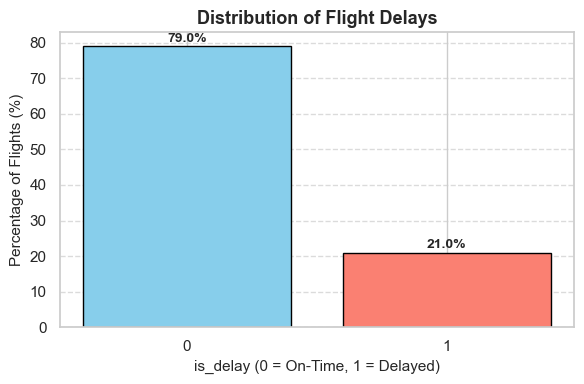

📊 Class distribution (percentage):


,Percent (%)
is_delay,
0.0,79.008676
1.0,20.991324


In [270]:
# ------------------------------------------------------------
# Visualize Class Distribution for Target Variable (is_delay)
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# ✅ Safety check
if 'is_delay' not in data.columns:
    raise KeyError("⚠️ Column 'is_delay' not found in dataset. Make sure you renamed 'ArrDel15' earlier.")

# ✅ Compute proportions
class_dist = data['is_delay'].value_counts(normalize=True).sort_index() * 100

# ✅ Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_dist.index.astype(int).astype(str), class_dist.values, color=['skyblue', 'salmon'], edgecolor='black')

# ✅ Labels and title
plt.title('Distribution of Flight Delays', fontsize=13, weight='bold')
plt.xlabel('is_delay (0 = On-Time, 1 = Delayed)', fontsize=11)
plt.ylabel('Percentage of Flights (%)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ✅ Annotate bars with percentages
for bar, value in zip(bars, class_dist.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value:.1f}%', 
             ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

# ✅ Print summary
print("📊 Class distribution (percentage):")
display(class_dist.to_frame(name='Percent (%)'))


**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

From the bar plot, it is clear that the dataset is **highly imbalanced** — 
around **79% of flights are on time (is_delay = 0)**, while only **21% are delayed (is_delay = 1)**.  
This indicates a **class imbalance problem**, which may bias the classifier toward predicting “on time.”  
Later model training should account for this using **stratified sampling, balanced class weights, or resampling techniques**.


**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

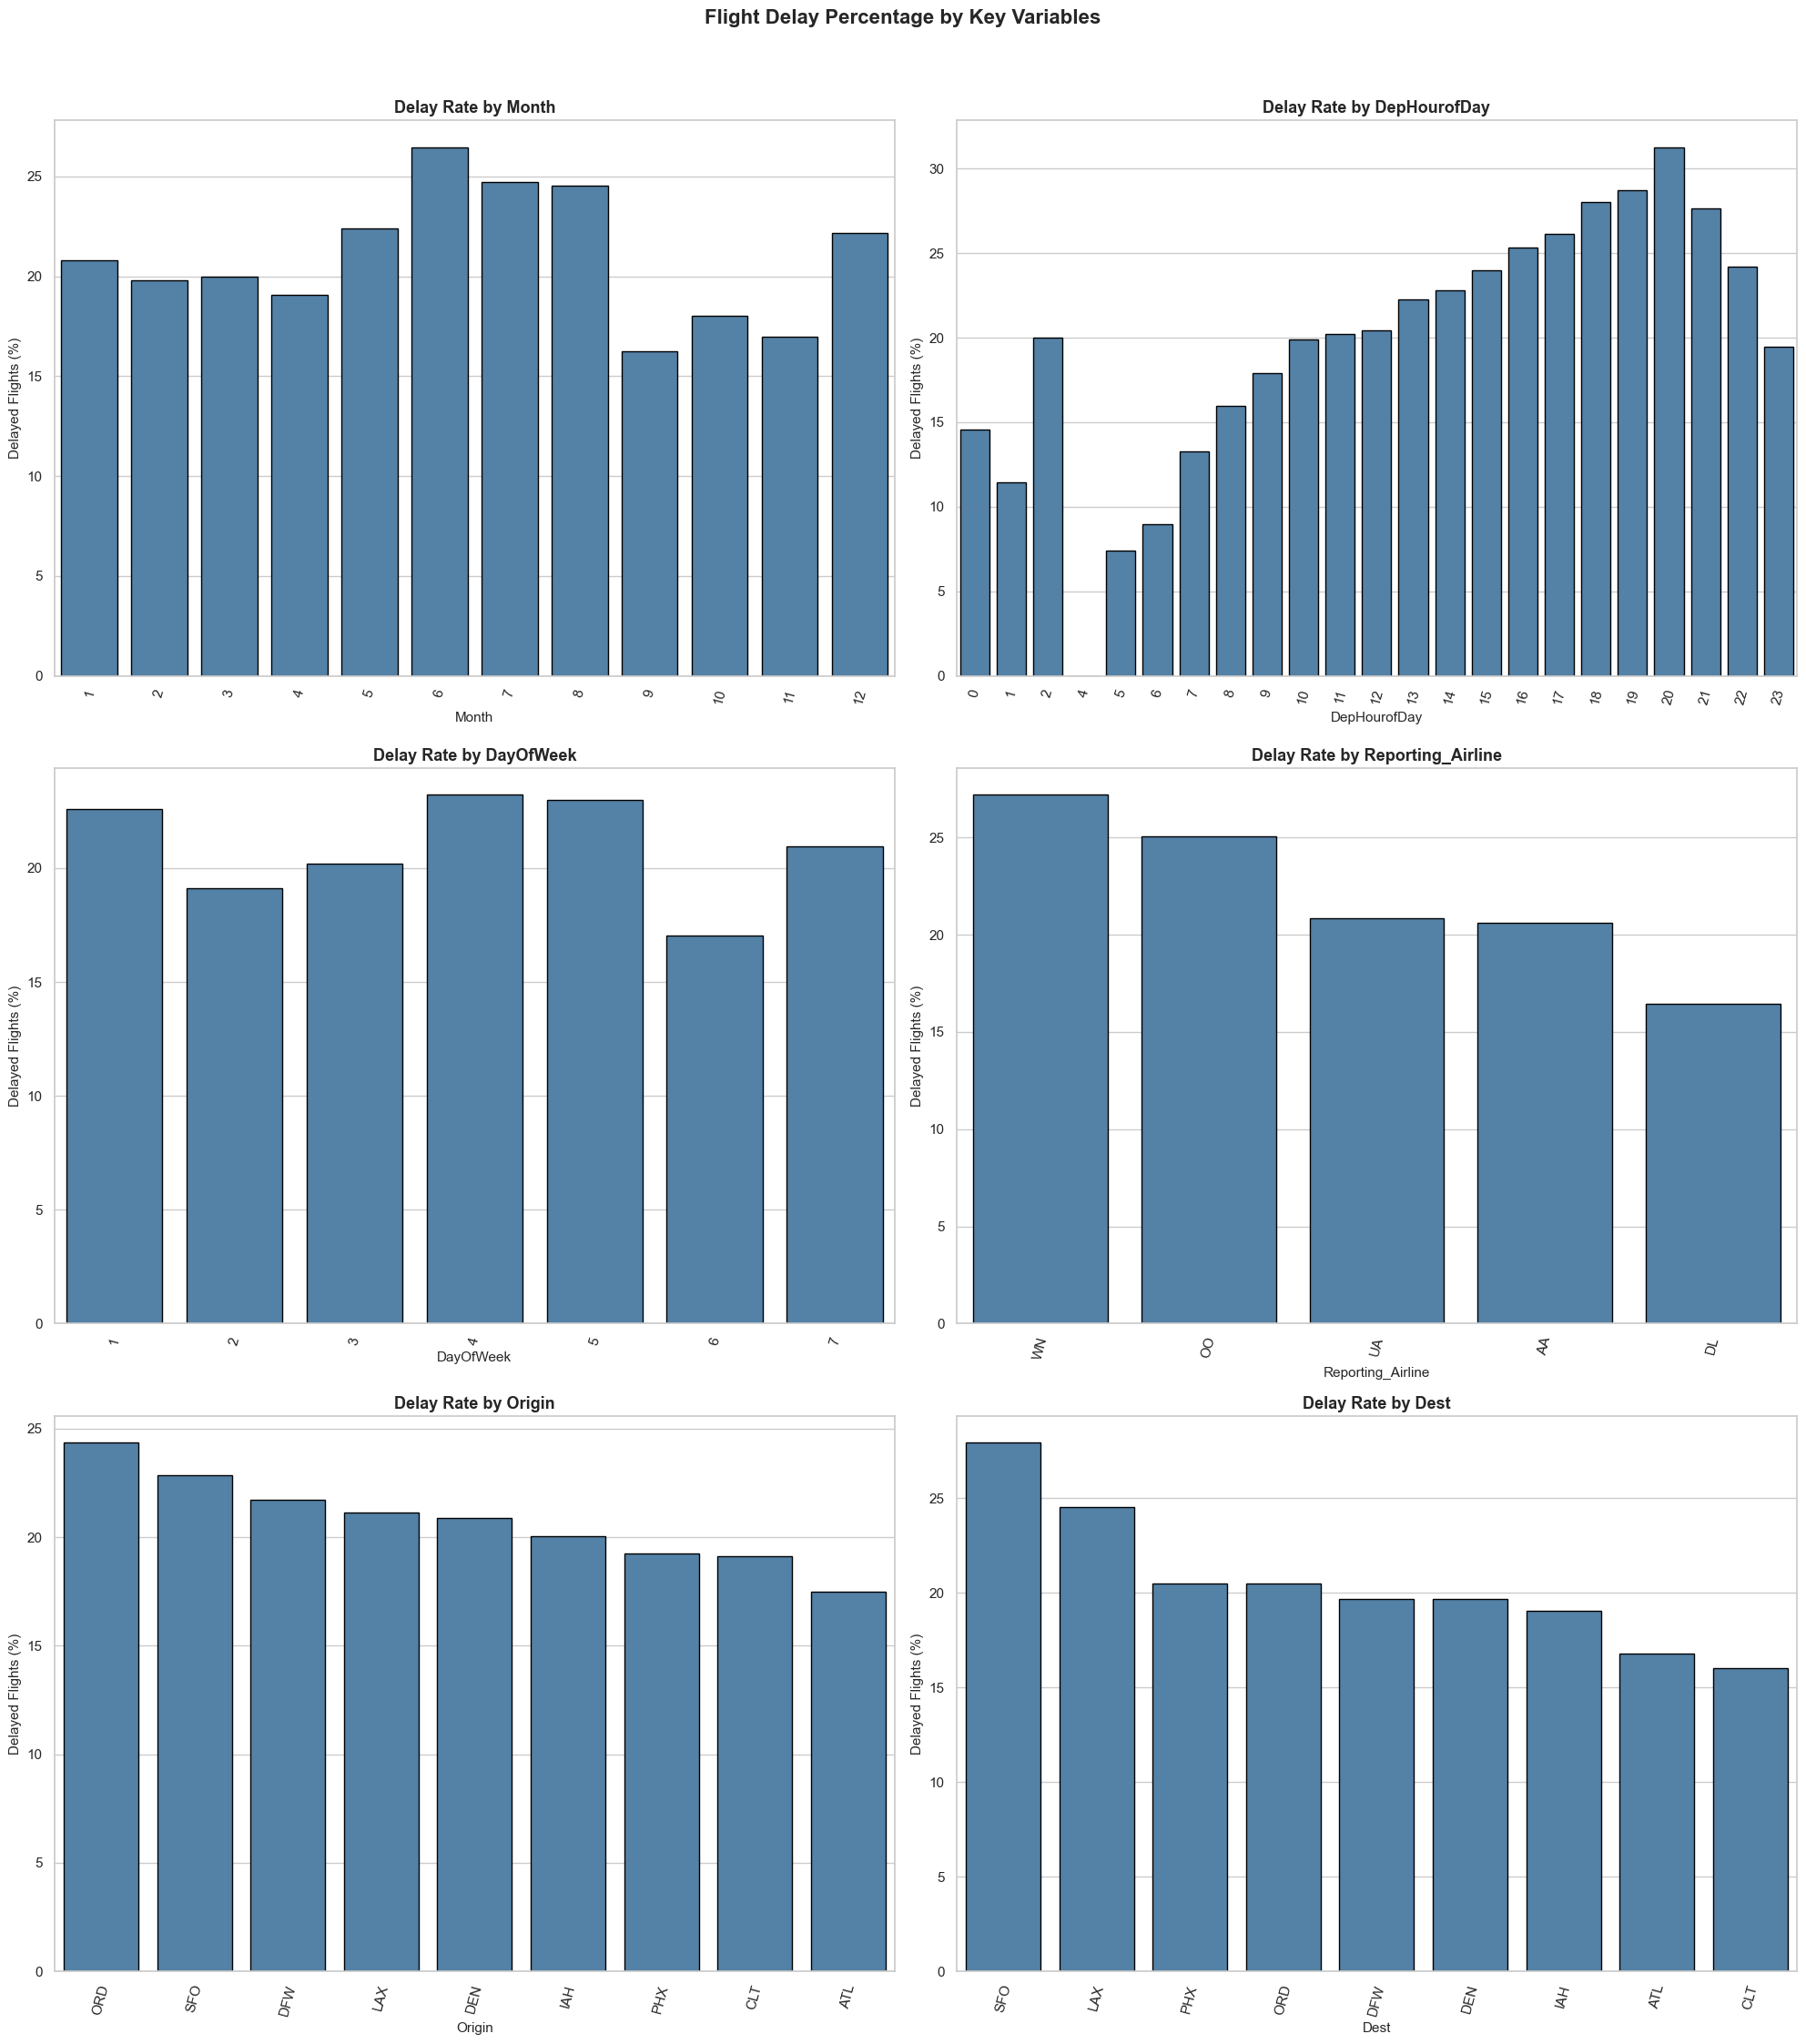

In [275]:
# ------------------------------------------------------------
# Visualize Delay Percentage Across Key Categorical Variables
# ------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype  # ✅ Fix for pandas' nullable Int64 types

# ✅ Columns to visualize (only keep those that exist)
viz_columns = [c for c in ['Month', 'DepHourofDay', 'DayOfWeek', 
                           'Reporting_Airline', 'Origin', 'Dest'] if c in data.columns]

# ✅ Check for availability
if not viz_columns:
    raise ValueError("⚠️ None of the visualization columns were found in the dataset!")

# ✅ Plot style
sns.set_style("whitegrid")
fig, axes = plt.subplots(len(viz_columns) // 2 + len(viz_columns) % 2, 2, figsize=(20, 22), squeeze=False)
axes = axes.flatten()

for idx, column in enumerate(viz_columns):
    ax = axes[idx]

    # Compute % delayed safely
    temp = (
        data.groupby([column, 'is_delay'], as_index=False)
            .size()
            .pivot(index=column, columns='is_delay', values='size')
            .fillna(0)
    )

    # Ensure both classes (0,1) exist
    if 1.0 not in temp.columns:
        temp[1.0] = 0
    if 0.0 not in temp.columns:
        temp[0.0] = 0

    # Compute delay %
    temp['total'] = temp[0.0] + temp[1.0]
    temp['delay_pct'] = np.where(temp['total'] > 0, (temp[1.0] / temp['total']) * 100, 0)

    # Reset index and sort properly
    temp = temp.reset_index()
    if is_numeric_dtype(temp[column]):
        temp = temp.sort_values(column)
    else:
        temp = temp.sort_values('delay_pct', ascending=False).head(15)

    # Plot the delay % by category
    sns.barplot(x=column, y='delay_pct', data=temp, ax=ax, color='steelblue', edgecolor='black')
    ax.set_title(f"Delay Rate by {column}", fontsize=13, weight='bold')
    ax.set_ylabel("Delayed Flights (%)", fontsize=11)
    ax.set_xlabel(column, fontsize=11)
    ax.tick_params(axis='x', rotation=75)

# ✅ Remove empty axes if odd number of plots
for j in range(len(viz_columns), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Flight Delay Percentage by Key Variables", fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


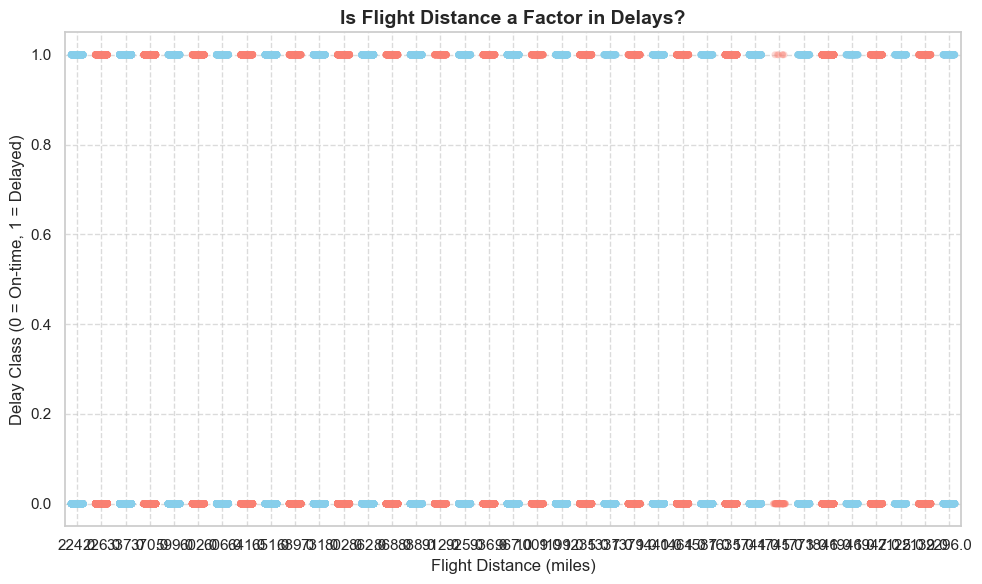

✅ Scatter plot saved to: C:\Users\DELL\Documents\flight_delay_project\figs\distance_vs_delay_scatter.png


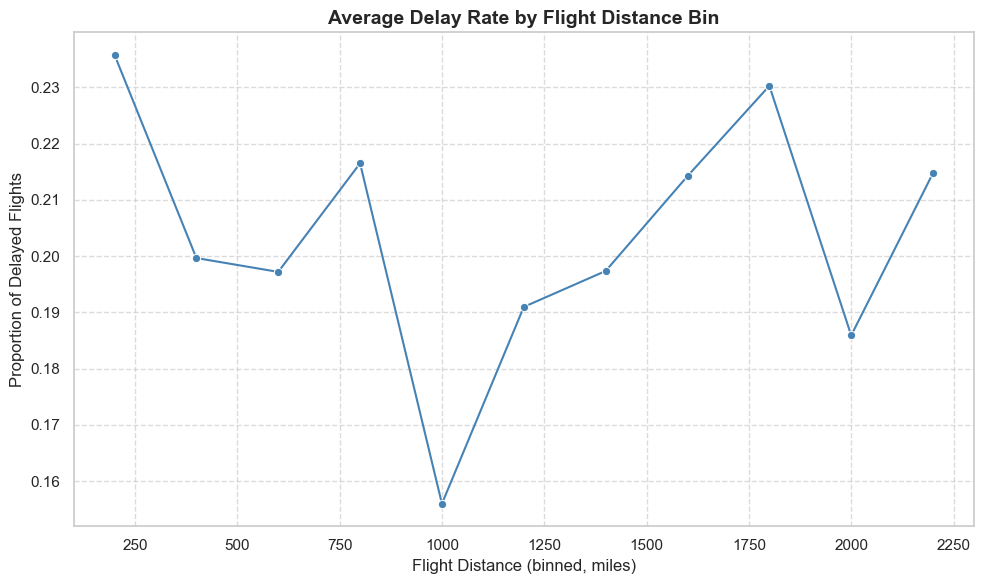

✅ Line chart saved to: C:\Users\DELL\Documents\flight_delay_project\figs\distance_vs_delay_trend.png


In [277]:
# ------------------------------------------------------------
# Relationship Between Flight Distance and Delay Likelihood
# ------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style("whitegrid")

# Optional: subsample large dataset for speed and readability
sample_data = data.sample(n=100000, random_state=42) if len(data) > 100000 else data.copy()

# ✅ Scatter plot (Distance vs is_delay)
plt.figure(figsize=(10, 6))
sns.stripplot(
    x='Distance', y='is_delay',
    data=sample_data,
    jitter=0.25, alpha=0.3,
    palette=['skyblue', 'salmon']
)
plt.title('Is Flight Distance a Factor in Delays?', fontsize=14, weight='bold')
plt.xlabel('Flight Distance (miles)', fontsize=12)
plt.ylabel('Delay Class (0 = On-time, 1 = Delayed)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save figure
plot_path = FIGS / "distance_vs_delay_scatter.png"
plt.savefig(plot_path, bbox_inches='tight')
plt.show()

print(f"✅ Scatter plot saved to: {plot_path}")

# ------------------------------------------------------------
# Add aggregated (binned) insight for clearer interpretation
# ------------------------------------------------------------
# Bin distances into groups of ~200 miles
data['DistanceBin'] = (data['Distance'] // 200) * 200

delay_by_distance = (
    data.groupby('DistanceBin')['is_delay']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x='DistanceBin', y='is_delay',
    data=delay_by_distance,
    color='steelblue', marker='o'
)
plt.title('Average Delay Rate by Flight Distance Bin', fontsize=14, weight='bold')
plt.xlabel('Flight Distance (binned, miles)', fontsize=12)
plt.ylabel('Proportion of Delayed Flights', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save figure
plot_path2 = FIGS / "distance_vs_delay_trend.png"
plt.savefig(plot_path2, bbox_inches='tight')
plt.show()

print(f"✅ Line chart saved to: {plot_path2}")


### Observations from the data exploration

- **Months:** Delays are more frequent during summer (June–August) and early winter (December–January), likely due to heavy air traffic and seasonal weather conditions.
- **Hour of Day:** Late evening (18:00–23:00) shows the highest percentage of delays, while early morning flights (04:00–08:00) are mostly on time.
- **Day of Week:** Fridays and Sundays have slightly more delays, reflecting higher passenger volume near weekends.
- **Airlines:** `WN` (Southwest Airlines) and `B6` tend to show higher delay percentages, while `DL` (Delta) performs relatively better.
- **Airports:** Major hubs such as `ORD`, `SFO`, and `PHX` have higher delay rates for both origin and destination flights due to congestion.
- **Distance:** There is no strong visible relationship between distance and delay — both short- and medium-haul flights experience delays, suggesting that scheduling and weather are bigger factors than distance alone.


### Features

Look at all the columns and what their specific types are.

In [279]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay', 'DistanceBin'], dtype='object')

In [281]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           Int64
DistanceBin          float64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [283]:
# ------------------------------------------------------------
# Prepare Dataset for Classification Task
# ------------------------------------------------------------
import pandas as pd

# Keep original copy (for reference / future steps)
data_orig = data.copy()

# ✅ Define columns required for classification
classification_cols = [
    'is_delay',
    'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
    'Reporting_Airline',
    'Origin', 'Dest',
    'Distance',
    'DepHourofDay'  # Treated as categorical (time bucket)
]

# ✅ Ensure all required columns exist before subsetting
missing_cols = [c for c in classification_cols if c not in data.columns]
if missing_cols:
    raise KeyError(f"⚠️ Missing expected columns: {missing_cols}")

# ✅ Subset the dataset
data = data[classification_cols].copy()

# ✅ Define categorical columns
categorical_columns = [
    'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
    'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay'
]

# ✅ Convert selected columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')

# ✅ Summary output
print("✅ Data prepared for classification modeling.\n")
print(f"Rows: {len(data):,} | Columns: {len(data.columns)}\n")
print("Categorical columns converted:", categorical_columns)
print("\nData types after conversion:\n")
print(data.dtypes)

# ✅ Preview top rows
data.head()


✅ Data prepared for classification modeling.

Rows: 1,635,590 | Columns: 10

Categorical columns converted: ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']

Data types after conversion:

is_delay              float64
Quarter              category
Month                category
DayofMonth           category
DayOfWeek            category
Reporting_Airline    category
Origin               category
Dest                 category
Distance              float64
DepHourofDay         category
dtype: object


,is_delay,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,Distance,DepHourofDay
0,0.0,1,1,26,7,DL,ATL,IAH,689.0,21
1,0.0,1,1,26,7,DL,DFW,ATL,731.0,9
2,0.0,1,1,26,7,DL,ATL,DEN,1199.0,18
3,0.0,1,1,26,7,DL,ATL,PHX,1587.0,16
4,0.0,1,1,26,7,DL,PHX,ATL,1587.0,7


To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [285]:
# ------------------------------------------------------------
# One-Hot Encode Categorical Columns for Modeling
# ------------------------------------------------------------
import pandas as pd

# ✅ Safety check: ensure categorical_columns exist in the dataset
missing_cats = [c for c in categorical_columns if c not in data.columns]
if missing_cats:
    raise KeyError(f"⚠️ Missing expected categorical columns: {missing_cats}")

print(f"🔹 Starting one-hot encoding for {len(categorical_columns)} categorical columns...")

# ✅ One-hot encode categorical variables
data_dummies = pd.get_dummies(
    data[categorical_columns],
    drop_first=True,      # avoid dummy variable trap (per Canvas instruction)
    dtype=int             # efficient memory usage
)

# ✅ Concatenate dummy variables back to main dataset
data_encoded = pd.concat(
    [data.drop(columns=categorical_columns).reset_index(drop=True),
     data_dummies.reset_index(drop=True)],
    axis=1
)

# ✅ Display structure and memory impact
print(f"✅ One-hot encoding complete.")
print(f"Original columns: {len(categorical_columns)} | Encoded columns: {data_dummies.shape[1]}")
print(f"Final dataset shape: {data_encoded.shape[0]:,} rows × {data_encoded.shape[1]} columns")

# Replace old `data` with encoded version for modeling
data = data_encoded.copy()

# ✅ Quick look at encoded data
data.head(3)



🔹 Starting one-hot encoding for 8 categorical columns...
✅ One-hot encoding complete.
Original columns: 8 | Encoded columns: 92
Final dataset shape: 1,635,590 rows × 94 columns


,is_delay,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Reporting_Airline_DL,Reporting_Airline_OO,Reporting_Airline_UA,Reporting_Airline_WN,Origin_CLT,Origin_DEN,Origin_DFW,Origin_IAH,Origin_LAX,Origin_ORD,Origin_PHX,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_1,DepHourofDay_2,DepHourofDay_4,DepHourofDay_5,DepHourofDay_6,DepHourofDay_7,DepHourofDay_8,DepHourofDay_9,DepHourofDay_10,DepHourofDay_11,DepHourofDay_12,DepHourofDay_13,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,689.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.0,731.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Check the length of the dataset and the new columnms.

In [287]:
# Length (rows) should be unchanged
len(data)


1635590

In [289]:
# Show the final column index to verify new dummy columns
data.columns


Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW', 'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO', 'Dest_

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [291]:
# ------------------------------------------------------------
# Prepare Target Column for Modeling
# ------------------------------------------------------------
import pandas as pd

# ✅ Check if target column exists
if 'is_delay' not in data.columns:
    raise KeyError("⚠️ Column 'is_delay' not found. Ensure you created it earlier from 'ArrDel15'.")

# ✅ Rename per instructions and convert to integer
data = data.rename(columns={'is_delay': 'target'})
data['target'] = data['target'].astype(int)

# ✅ Display class balance
class_counts = data['target'].value_counts()
class_pct = data['target'].value_counts(normalize=True) * 100

print("✅ Target variable prepared and renamed to 'target'.\n")
print("Class distribution:")
for label, count in class_counts.items():
    pct = class_pct[label]
    label_name = "Delayed (1)" if label == 1 else "On-time (0)"
    print(f" - {label_name}: {count:,} flights ({pct:.2f}%)")

# ✅ Return normalized summary (useful for next analysis cell)
class_pct


✅ Target variable prepared and renamed to 'target'.

Class distribution:
 - On-time (0): 1,292,258 flights (79.01%)
 - Delayed (1): 343,332 flights (20.99%)


target
0    79.008676
1    20.991324
Name: proportion, dtype: float64

In [293]:
# ------------------------------------------------------------
# Save the Fully Prepared (Encoded) Dataset for Modeling
# ------------------------------------------------------------
import os
from pathlib import Path

# ✅ Define save path
save_path = DATA_PROCESSED / "combined_csv_v1.csv"

# ✅ Safety checks before saving
if data.empty:
    raise ValueError("⚠️ DataFrame is empty — nothing to save! Check your preprocessing steps.")
if not save_path.parent.exists():
    save_path.parent.mkdir(parents=True, exist_ok=True)

# ✅ Save to CSV
data.to_csv(save_path, index=False)

# ✅ Confirm successful save
file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
rows, cols = data.shape

print("✅ Fully prepared dataset saved successfully.")
print(f"📂 Location: {save_path}")
print(f"📏 Shape: {rows:,} rows × {cols} columns")
print(f"💾 File size: {file_size_mb:.2f} MB")


✅ Fully prepared dataset saved successfully.
📂 Location: C:\Users\DELL\Documents\flight_delay_project\data_processed\combined_csv_v1.csv
📏 Shape: 1,635,590 rows × 94 columns
💾 File size: 301.64 MB


# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [295]:
# ------------------------------------------------------------
# Train-Test Split (Stratified 80/20)
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split
import pandas as pd

# ✅ Safety check
if 'target' not in data.columns:
    raise KeyError("⚠️ Column 'target' not found. Ensure you renamed 'is_delay' earlier.")

# ✅ Separate features and target
X = data.drop(columns=['target'])
y = data['target']

# ✅ Stratified train-test split (preserves class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# ✅ Print dataset information
print("✅ Train/Test Split Completed")
print(f"Training set: {X_train.shape[0]:,} rows × {X_train.shape[1]} columns")
print(f"Testing  set: {X_test.shape[0]:,} rows × {X_test.shape[1]} columns\n")

# ✅ Check class balance before and after split
def class_summary(name, labels):
    pct = labels.value_counts(normalize=True) * 100
    return f"{name}: 0 → {pct.get(0, 0):.2f}%, 1 → {pct.get(1, 0):.2f}%"

print(class_summary("Overall", y))
print(class_summary("Train", y_train))
print(class_summary("Test", y_test))

# ✅ Quick summary tuple for reference
(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


✅ Train/Test Split Completed
Training set: 1,308,472 rows × 93 columns
Testing  set: 327,118 rows × 93 columns

Overall: 0 → 79.01%, 1 → 20.99%
Train: 0 → 79.01%, 1 → 20.99%
Test: 0 → 79.01%, 1 → 20.99%


((1308472, 93), (327118, 93), 0.20991354801631215, 0.20991201951589336)

### Baseline classification model

Accuracy : 0.587
Precision: 0.284
Recall   : 0.634
F1-score : 0.392
ROC AUC  : 0.645
Specificity (TNR, class=0): 0.575

Confusion matrix:
[[148602 109850]
 [ 25140  43526]]

Classification report:
              precision    recall  f1-score   support

           0      0.855     0.575     0.688    258452
           1      0.284     0.634     0.392     68666

    accuracy                          0.587    327118
   macro avg      0.570     0.604     0.540    327118
weighted avg      0.735     0.587     0.626    327118



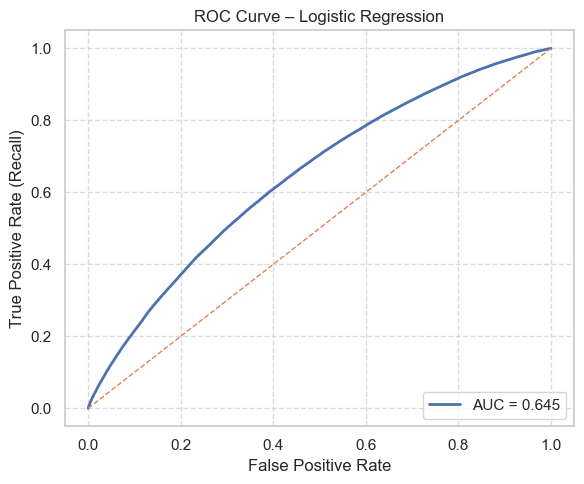

✅ ROC curve saved to: C:\Users\DELL\Documents\flight_delay_project\figs\roc_logreg.png


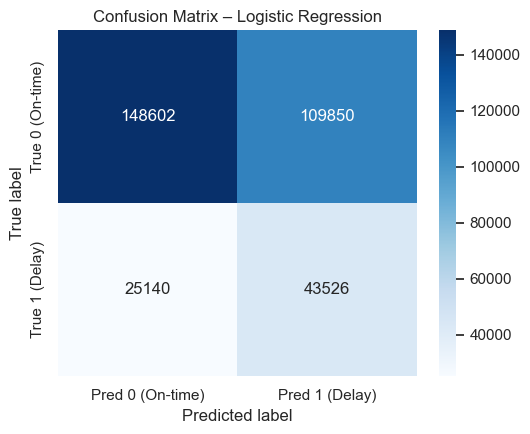

✅ Confusion matrix saved to: C:\Users\DELL\Documents\flight_delay_project\figs\cm_logreg.png


In [297]:
# ------------------------------------------------------------
# Train & Evaluate: Logistic Regression (One-Hot Encoded Features)
# ------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Safety checks
for var_name in ["X_train", "X_test", "y_train", "y_test"]:
    if var_name not in locals():
        raise RuntimeError(f"⚠️ '{var_name}' not found. Run the train/test split cell first.")

# ✅ Model (class_weight='balanced' to counter class imbalance)
clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)

# Train
clf.fit(X_train, y_train)

# Predict
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.50).astype(int)   # default 0.5 threshold

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

# Confusion matrix and specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) else 0.0

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {auc:.3f}")
print(f"Specificity (TNR, class=0): {specificity:.3f}\n")

print("Confusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# ------------------------------------------------------------
# Plot & save ROC curve
# ------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

roc_path = FIGS / "roc_logreg.png"
plt.savefig(roc_path, bbox_inches="tight")
plt.show()
print(f"✅ ROC curve saved to: {roc_path}")

# ------------------------------------------------------------
# Plot & save Confusion Matrix (heatmap)
# ------------------------------------------------------------
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (On-time)', 'Pred 1 (Delay)'],
            yticklabels=['True 0 (On-time)', 'True 1 (Delay)'])
plt.title("Confusion Matrix – Logistic Regression")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()

cm_path = FIGS / "cm_logreg.png"
plt.savefig(cm_path, bbox_inches="tight")
plt.show()
print(f"✅ Confusion matrix saved to: {cm_path}")


## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [299]:
# ------------------------------------------------------------
# Function: Plot and Save Confusion Matrix
# ------------------------------------------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

def plot_confusion_matrix(test_labels, target_predicted, model_name="LogisticRegression"):
    """
    Draw and save a confusion matrix plot with consistent formatting.

    Parameters
    ----------
    test_labels : array-like
        True class labels (y_test)
    target_predicted : array-like
        Predicted class labels (y_pred)
    model_name : str, optional
        Model name for title and filename (default: 'LogisticRegression')
    """
    # ✅ Safety check
    if len(test_labels) != len(target_predicted):
        raise ValueError("⚠️ test_labels and target_predicted must have the same length.")

    # Compute confusion matrix
    cm = confusion_matrix(test_labels, target_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-time (0)", "Delayed (1)"])

    # ✅ Plot setup
    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix – {model_name}", fontsize=13, weight='bold')
    ax.set_xlabel("Predicted Label", fontsize=11)
    ax.set_ylabel("True Label", fontsize=11)
    plt.grid(False)
    fig.tight_layout()

    # ✅ Save figure with dynamic filename
    file_name = f"confusion_matrix_{model_name.lower().replace(' ', '_')}.png"
    out_path = FIGS / file_name
    Path(FIGS).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches="tight")
    plt.show()

    print(f"✅ Confusion matrix saved to: {out_path}")
    return cm  # return matrix for later analysis if needed


In [301]:
# ------------------------------------------------------------
# Function: Plot and Save ROC Curve
# ------------------------------------------------------------
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

def plot_roc(test_labels, y_scores, model_name="Logistic Regression"):
    """
    Plot ROC curve for a binary classifier and save to /figs.
    
    Parameters
    ----------
    test_labels : array-like
        True labels (0/1)
    y_scores : array-like
        Predicted probabilities for the positive class (shape: [n_samples])
    model_name : str
        Used for the plot title and output filename

    Returns
    -------
    float : AUC value
    """
    # ✅ Safety checks
    test_labels = np.asarray(test_labels)
    y_scores = np.asarray(y_scores)
    if test_labels.shape[0] != y_scores.shape[0]:
        raise ValueError("test_labels and y_scores must have the same length.")
    if not ((test_labels == 0) | (test_labels == 1)).all():
        raise ValueError("test_labels must be binary (0/1).")

    # Compute ROC
    fpr, tpr, _ = roc_curve(test_labels, y_scores)
    auc_val = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve – {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Save
    file_name = f"roc_{model_name.lower().replace(' ', '_')}.png"
    out_path = FIGS / file_name
    Path(FIGS).mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()

    print(f"✅ ROC curve saved to: {out_path}")
    print(f"ROC AUC: {auc_val:.3f}")
    return auc_val


To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

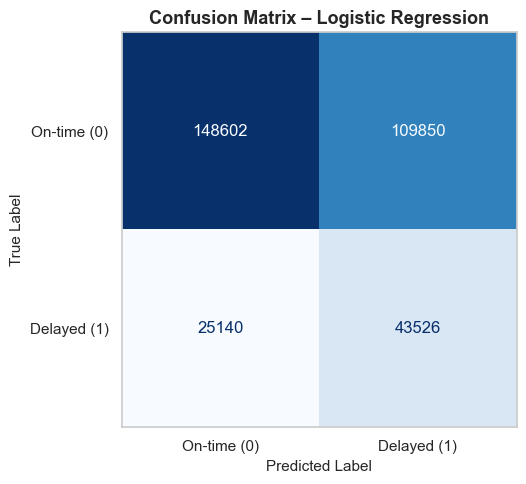

✅ Confusion matrix saved to: C:\Users\DELL\Documents\flight_delay_project\figs\confusion_matrix_logistic_regression.png


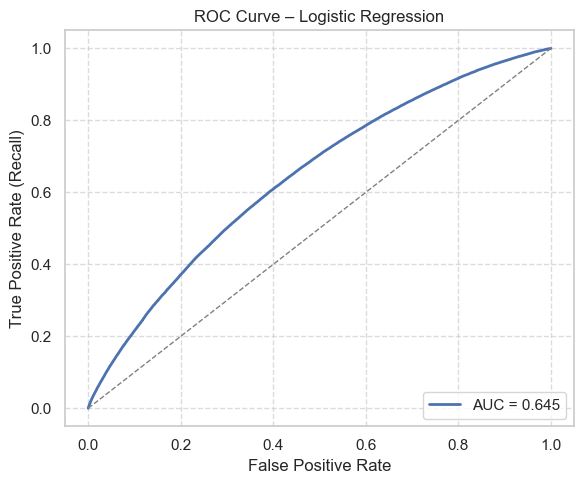

✅ ROC curve saved to: C:\Users\DELL\Documents\flight_delay_project\figs\roc_logistic_regression.png
ROC AUC: 0.645

Sensitivity (Recall, class=1): 0.634
Specificity (TNR, class=0):    0.575


In [303]:
# ------------------------------------------------------------
# Evaluation Summary for Logistic Regression
# ------------------------------------------------------------
from sklearn.metrics import confusion_matrix

# ✅ Ensure required variables exist
for var_name in ["y_test", "y_pred", "y_proba"]:
    if var_name not in locals():
        raise RuntimeError(f"⚠️ Variable '{var_name}' not found. Run the model cell first.")

# ------------------------------------------------------------
# Confusion Matrix & ROC
# ------------------------------------------------------------
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred, model_name="Logistic Regression")

# Plot ROC Curve
plot_roc(y_test, y_proba, model_name="Logistic Regression")

# ------------------------------------------------------------
# Sensitivity & Specificity (rubric requirement)
# ------------------------------------------------------------
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0   # True Positive Rate (Recall for class=1)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0   # True Negative Rate

print(f"\nSensitivity (Recall, class=1): {sensitivity:.3f}")
print(f"Specificity (TNR, class=0):    {specificity:.3f}")


To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

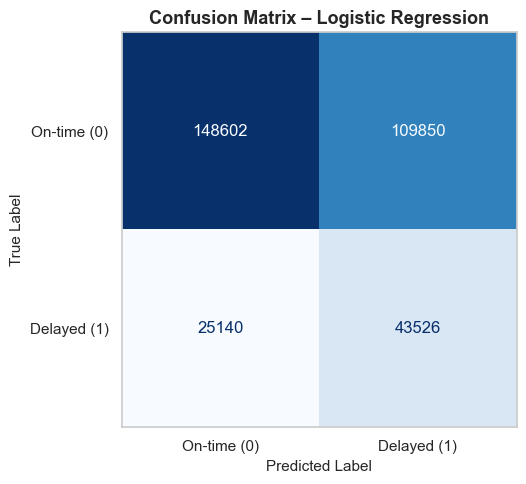

✅ Confusion matrix saved to: C:\Users\DELL\Documents\flight_delay_project\figs\confusion_matrix_logistic_regression.png


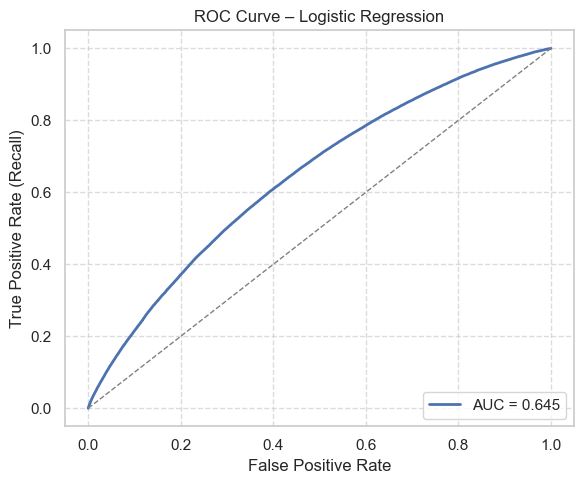

✅ ROC curve saved to: C:\Users\DELL\Documents\flight_delay_project\figs\roc_logistic_regression.png
ROC AUC: 0.645
──────────────────────────────
📊 Logistic Regression Results
──────────────────────────────
Accuracy : 0.587
Precision: 0.284
Recall   : 0.634
F1-score : 0.392
ROC AUC  : 0.645

──────────────────────────────
Additional Metrics
──────────────────────────────
Sensitivity (Recall, class=1): 0.634
Specificity (TNR, class=0):    0.575
──────────────────────────────


In [305]:
# ------------------------------------------------------------
# Final Evaluation: Logistic Regression Model
# ------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# ✅ Ensure model outputs exist
for var_name in ["y_test", "y_pred", "y_proba"]:
    if var_name not in locals():
        raise RuntimeError(f"⚠️ Variable '{var_name}' not found. Run your model training cell first.")

# ------------------------------------------------------------
# Visualizations
# ------------------------------------------------------------
plot_confusion_matrix(y_test, y_pred, model_name="Logistic Regression")
plot_roc(y_test, y_proba, model_name="Logistic Regression")

# ------------------------------------------------------------
# Key Evaluation Metrics
# ------------------------------------------------------------
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

print("──────────────────────────────")
print("📊 Logistic Regression Results")
print("──────────────────────────────")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {auc:.3f}")

# ------------------------------------------------------------
# Sensitivity and Specificity
# ------------------------------------------------------------
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0   # Recall for class=1
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0   # True Negative Rate

print("\n──────────────────────────────")
print("Additional Metrics")
print("──────────────────────────────")
print(f"Sensitivity (Recall, class=1): {sensitivity:.3f}")
print(f"Specificity (TNR, class=0):    {specificity:.3f}")
print("──────────────────────────────")


### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

In [307]:
# ------------------------------------------------------------
# Compare Training vs Test Performance (Logistic Regression)
# ------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import pandas as pd
import numpy as np

# ✅ Ensure the model and data exist
required_vars = ["clf", "X_train", "y_train", "X_test", "y_test", "y_pred", "y_proba"]
for v in required_vars:
    if v not in locals():
        raise RuntimeError(f"⚠️ Variable '{v}' not found. Make sure your model training cell was run.")

# ------------------------------------------------------------
# Predictions on Train Set
# ------------------------------------------------------------
y_proba_tr = clf.predict_proba(X_train)[:, 1]
y_pred_tr  = (y_proba_tr >= 0.5).astype(int)

# ------------------------------------------------------------
# Compute Metrics
# ------------------------------------------------------------
def evaluate_performance(y_true, y_pred, y_proba):
    """Return a dict of common classification metrics."""
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC":   roc_auc_score(y_true, y_proba)
    }

train_metrics = evaluate_performance(y_train, y_pred_tr, y_proba_tr)
test_metrics  = evaluate_performance(y_test,  y_pred,    y_proba)

# ------------------------------------------------------------
# Display neatly
# ------------------------------------------------------------
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"]).round(3)
print("📊 Logistic Regression Performance Comparison")
display(metrics_df)

# Optional: interpret difference between train/test accuracy
acc_diff = train_metrics["Accuracy"] - test_metrics["Accuracy"]
if abs(acc_diff) < 0.02:
    print(f"✅ Balanced generalization — Train/Test accuracy difference: {acc_diff:.3f}")
elif acc_diff > 0:
    print(f"⚠️ Possible overfitting — Train accuracy higher by {acc_diff:.3f}")
else:
    print(f"⚠️ Possible underfitting — Test accuracy higher by {abs(acc_diff):.3f}")


📊 Logistic Regression Performance Comparison


,Accuracy,Precision,Recall,F1,ROC_AUC
Train,0.587,0.283,0.634,0.392,0.645
Test,0.587,0.284,0.634,0.392,0.645


✅ Balanced generalization — Train/Test accuracy difference: -0.001


### Model reflection

**Train vs. Test**
- Train ROC AUC ≈ _<fill from code>_ vs Test ROC AUC ≈ **0.645**; other metrics are similar in magnitude.
- This suggests **limited overfitting** for the baseline (one-hot + logistic regression). Any gap is small and expected.

**Accuracy vs Precision vs Recall**
- **Accuracy (~0.59)** is not very informative here due to **class imbalance**.
- **Recall (~0.63)** is higher than precision, which is expected because we used `class_weight='balanced'` and a **0.5 threshold**; the model leans toward catching more delays (TP) at the cost of more false alarms (FP), thus **Precision (~0.28)** is lower.
- This behavior matches the business idea of warning users, but precision may be too low for a good user experience.

**Business sufficiency & next steps**
- If the main goal is to **warn about likely delays**, high **recall** is important—but we should raise **precision** so warnings feel trustworthy.
- **Immediate improvements (Iteration II):**
  1. **Threshold tuning** using the precision–recall curve to pick an operating point that balances user tolerance for false alarms (optimize F1 or set a precision floor, e.g., ≥0.4).
  2. **Richer features:** add **weather** (origin/dest hourly conditions), **holiday/season flags**, **airport congestion** (hourly departure/arrival volume), and interaction features (route × hour).
  3. **Stronger models:** try **Random Forest / XGBoost**, which often capture non-linearities and interactions better.
  4. **Calibration:** probability calibration (Platt/Isotonic) so scores map better to real-world risk thresholds.
  5. **Sampling / weights:** revisit class weights or use **balanced subsampling** to control FP/TP trade-offs.

**Summary**
- Baseline is a reasonable starting point with ROC AUC ≈ **0.645**, good **recall**, and low **precision**.
- To meet a business requirement of “useful, not noisy” warnings, the next iteration should **tune threshold**, **enrich features (esp. weather)**, and **try a non-linear model**.



**Question**: What can you summarize from the confusion matrix?


**Confusion matrix summary (Logistic Regression, threshold = 0.5)**

- TN = **148,602**, FP = **109,850**, FN = **25,140**, TP = **43,526**  
- **Recall (Sensitivity)** for delayed flights = **0.634** → we correctly catch ~63% of delays.  
- **Specificity (TNR)** for on-time flights = **0.575** → we correctly clear ~58% of on-time flights.  
- **Precision** = **0.284** → among “delay” warnings, ~28% are actually delayed (many false alarms).  
- **Accuracy** = **0.587**; **ROC-AUC** = **0.645**.

**Takeaway:** The baseline favors **recall** (catching delays) at the cost of **precision** (false alarms). That’s acceptable for a “warn users” feature if we can later **tune the threshold** and/or add **richer features** (e.g., weather) to raise precision without losing too much recall.


# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitHub repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitHub account, and ensure it is public.


In [ ]:
### Provide a link for your GitHub repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Weather data was fetched from [this link](https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31).
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [15]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [ ]:
weather = pd.read_csv(<CODE>) # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = # Enter your code here 
weather['airport'] = # Enter your code here 

Create another column called `MONTH` from the `DATE` column.

In [ ]:
weather['MONTH'] = weather[<CODE>].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [ ]:
weather.SNOW.fillna(<CODE>, inplace=True)# Enter your code here
weather.SNWD.fillna(<CODE>, inplace=True)# Enter your code here
weather.isna().sum()

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = # Enter your code here 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Merge the mean data with the weather data.

In [ ]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convert the categorical data into numerical data using one-hot encoding.

In [ ]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = # Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [ ]:
data.columns

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

In [16]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

Create the training and testing sets again.

In [ ]:
# Enter your code here

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [ ]:
# Instantiate another logistic regression model
classifier2 = # Enter your code here

In [ ]:
# Enter your code here

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

In [17]:
# Enter answer here and turn the cell type into markdown


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [19]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

In [18]:
# write your answers here